In [1]:
import numpy as np
from dgamod import *
import cmath as cm
import matplotlib as mpl
import matplotlib.pyplot as plt
from numpy import random
import pandas as pd
import configparser
import sys
import os
import matplotlib.animation as animation
from drl_grams import *

mpl.rcParams.update({'font.size': 12})
plt.rcParams['axes.axisbelow'] = True
%matplotlib widget
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.linewidth'] = 2
#mpl.rcParams['axes.prop_cycle'] = cycler(color='bgrkmyc')

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["b", "g", "r", 'k','y' , 'm','tab:orange', 'tab:cyan', 'tab:brown', 'slategrey', 'deeppink' ]) 

In [2]:
def state_fidelity(state):
    nh = np.shape(state)[0]
    fid = np.real(state[nh-1]*np.conjugate(state[nh-1]))
    return fid

In [3]:
def calc_exp_value(state, op):
    val = np.matmul(np.conjugate(np.transpose(state)),np.matmul(op, state))
    return np.real(val)

In [4]:
def calc_ipr(state):
    nh = np.shape(state)[0]
    ipr = 0
    for i in range(nh):
        ipr += np.real(state[i]*np.conjugate(state[i]))**2
    return ipr

In [5]:
def calc_localization(state):
    nh = np.shape(state)[0]
    loc = 0
    for i in range(nh):
        loc += np.real(state[i]*np.conjugate(state[i]))**2*(i+1)
    return loc

In [6]:
def action_selector(actions_name,b,nh):

    if actions_name == 'original':
        actions = actions_paper2(b, nh)
    elif actions_name == 'new':
        actions = new_actions(b,nh)
    elif actions_name == 'old':
        actions = actions_paper(b,nh)
    elif actions_name == 'four':
        actions = actions4(b,1,nh)
    elif actions_name == 'oaps':
        actions = one_field_actions(b,nh)
    elif actions_name == 'extra':
        actions = one_field_actions_extra(b,nh)
    
    return actions
    

In [7]:
def plot_single_sequence(action_sequence,nh,dt=0.15,b=100,label='',actions = 'original',add_natural=False):
    
    action_sequence = [int(x) for x in action_sequence]
    t_steps = len(action_sequence)+1
    
    # generar propagadores
    actions = action_selector(actions,b,nh)
    propagators = gen_props(actions, nh, b, dt)
    times = np.arange(0,t_steps,1)

    # definicion del estado inicial e inicializacion de estados forzado y natural

    initial_state = np.zeros(nh, dtype=np.complex_)
    initial_state[0] = 1.0

    free_state = initial_state
    
    if add_natural:
        natural_evol = [state_fidelity(free_state)]
    
        nat_sequence = np.zeros(int(t_steps-1),dtype=int)

        for action in nat_sequence:
                
            free_state = calculate_next_state(free_state,0,propagators)
            natural_evol.append(state_fidelity(free_state))

        max_natural = np.max(natural_evol)

        plt.plot(times,natural_evol, '-v', label = 'Natural Evolution , Máx: {}'.format(max_natural))
    

    # inicializacion de estado forzado 
    forced_state = initial_state

    # almacenar evolucion natural y evolucion forzada
    forced_evol = [state_fidelity(forced_state)]

    for action in action_sequence:
        
        forced_state = calculate_next_state(forced_state,action,propagators)
        forced_evol.append(state_fidelity(forced_state))

    max_forced = np.max(forced_evol)

    plt.plot(times,forced_evol,'-o', label = label + '. Máx.: {}'.format(max_forced))

    plt.legend(loc='upper left')
    #plt.show()


In [8]:
def plot_exp_value(action_sequence,nh,dt=0.15,b=100,label='',actions = 'original',add_actions=False):
    
    if add_actions:
        add_actions = plt.subplots()

    action_sequence = [int(x) for x in action_sequence]
    t_steps = len(action_sequence)
    
    # generar propagadores
    actions = action_selector(actions,b,nh)
    propagators = gen_props(actions, nh, b, dt)
    times = np.arange(0,t_steps,1)

    # definicion del estado inicial e inicializacion de estados forzado y natural

    initial_state = np.zeros(nh, dtype=np.complex_)
    initial_state[0] = 1.0

    zero_action = actions_paper2(b,nh)[0]

    # inicializacion de estado forzado 
    forced_state = initial_state

    # almacenar evolucion natural y evolucion forzada
    exp_values = []

    for action in action_sequence:
        
        forced_state = calculate_next_state(forced_state,action,propagators)
        exp_values.append(calc_exp_value(forced_state,actions[action]))

    max_exp_val = np.max(exp_values)

    plt.plot(times,exp_values,'-o', label = label + '. Máx.: {}'.format(max_exp_val))

    plt.legend(loc='upper left')
    
    if add_actions:
        ax2 = add_actions[1].twinx()

        color = 'tab:grey'
        ax2.plot(action_sequence,'--o',label='Acciones',color=color)

        ax2.tick_params(axis='y', labelcolor=color)

        add_actions[0].tight_layout()
    


In [9]:
def plot_ipr(action_sequence,nh,dt=0.15,b=100,label='',actions = 'original',add_actions=False):
    
    if add_actions:
        add_actions = plt.subplots()

    action_sequence = [int(x) for x in action_sequence]
    t_steps = len(action_sequence)+1
    
    # generar propagadores
    actions = action_selector(actions,b,nh)        
    propagators = gen_props(actions, nh, b, dt)
    times = np.arange(0,t_steps,1)

    # definicion del estado inicial e inicializacion de estados forzado y natural

    initial_state = np.zeros(nh, dtype=np.complex_)
    initial_state[0] = 1.0

    zero_action = actions_paper2(b,nh)[0]

    # inicializacion de estado forzado 
    forced_state = initial_state

    # almacenar evolucion natural y evolucion forzada
    ipr_values = [calc_ipr(forced_state)]

    for action in action_sequence:
        
        forced_state = calculate_next_state(forced_state,action,propagators)
        ipr_values.append(calc_ipr(forced_state))

    max_exp_val = np.max(ipr_values)

    plt.plot(times,ipr_values,'-o', label = label + '. Máx.: {}'.format(max_exp_val))

    plt.legend(loc='upper left')
    
    if add_actions:
        ax2 = add_actions[1].twinx()

        color = 'tab:grey'
        ax2.plot(action_sequence,'--o',label='Acciones',color=color)

        ax2.tick_params(axis='y', labelcolor=color)

        add_actions[0].tight_layout()

In [10]:
def plot_localization(action_sequence,nh,dt=0.15,b=100,label='',actions = 'original',add_actions=False):
    
    if add_actions:
        add_actions = plt.subplots()

    action_sequence = [int(x) for x in action_sequence]
    t_steps = len(action_sequence)+1
    
    # generar propagadores
    actions = action_selector(actions,b,nh)
    propagators = gen_props(actions, nh, b, dt)
    times = np.arange(0,t_steps,1)

    # definicion del estado inicial e inicializacion de estados forzado y natural

    initial_state = np.zeros(nh, dtype=np.complex_)
    initial_state[0] = 1.0

    zero_action = actions_paper2(b,nh)[0]

    # inicializacion de estado forzado 
    forced_state = initial_state

    # almacenar evolucion natural y evolucion forzada
    loc_values = [calc_localization(forced_state)]

    for action in action_sequence:
        
        forced_state = calculate_next_state(forced_state,action,propagators)
        loc_values.append(calc_localization(forced_state))

    max_loc_values = np.max(loc_values)

    plt.plot(times,loc_values,'-o', label = label + '. Máx.: {}'.format(max_loc_values))

    plt.legend(loc='upper left')
    
    if add_actions:
        ax2 = add_actions[1].twinx()

        color = 'tab:grey'
        ax2.plot(action_sequence,'--o',label='Acciones',color=color)

        ax2.tick_params(axis='y', labelcolor=color)

        add_actions[0].tight_layout()
    


In [11]:
def plot_all_metrics(action_sequence, nh, dt=0.15, b=100, label='', actions='original', add_natural=False, add_actions=False):
    """
    Genera una grilla 2x2 con las siguientes gráficas:
    - Fidelidad (single_sequence)
    - IPR
    - Valor esperado (exp_value)
    - Localización
    """
    action_sequence = [int(x) for x in action_sequence]
    t_steps = len(action_sequence) + 1
    times = np.arange(0, t_steps, 1)
    
    # Generar propagadores
    actions = action_selector(actions,b,nh)
    propagators = gen_props(actions, nh, b, dt)
    
    # Inicializar estado inicial
    initial_state = np.zeros(nh, dtype=np.complex_)
    initial_state[0] = 1.0
    
    # Configurar la figura
    fig, axs = plt.subplots(2, 2, figsize=(12, 7))
    axs = axs.ravel()  # Facilita el acceso a los subplots
    
    # Función auxiliar para agregar acciones
    def plot_actions(ax):
        if add_actions:
            ax2 = ax.twinx()
            color = 'tab:grey'
            ax2.plot(range(len(action_sequence)), action_sequence, '--o', label='Acciones', color=color)
            ax2.tick_params(axis='y', labelcolor=color)
            ax2.legend(loc='upper right')

    # 1. Fidelidad
    free_state = initial_state
    forced_state = initial_state
    forced_evol = [state_fidelity(forced_state)]
    
    for action in action_sequence:
        forced_state = calculate_next_state(forced_state, action, propagators)
        forced_evol.append(state_fidelity(forced_state))
    axs[0].plot(times, forced_evol, '-o', label=f"{label}. Máx.: {max(forced_evol)}")
    axs[0].set_title("Fidelidad")
    axs[0].legend(loc='upper left')
    if 0 in add_actions:
        plot_actions(axs[0])
    
    # 2. IPR
    forced_state = initial_state
    ipr_values = [calc_ipr(forced_state)]
    
    for action in action_sequence:
        forced_state = calculate_next_state(forced_state, action, propagators)
        ipr_values.append(calc_ipr(forced_state))
    axs[1].plot(times, ipr_values, '-o', label=f"{label}. Máx.: {max(ipr_values)}")
    axs[1].set_title("IPR")
    axs[1].legend(loc='upper left')

    if 1 in add_actions:
        plot_actions(axs[1])
    
    # 3. Valor esperado
    forced_state = initial_state
    exp_values = []
    for action in action_sequence:
        forced_state = calculate_next_state(forced_state, action, propagators)
        exp_values.append(calc_exp_value(forced_state, actions[action]))
    axs[2].plot(times[:-1], exp_values, '-o', label=f"{label}. Máx.: {max(exp_values)}")
    axs[2].set_title("Valor Esperado")
    axs[2].legend(loc='upper left')
    if 2 in add_actions:
        plot_actions(axs[2])
    
    # 4. Localización
    forced_state = initial_state
    loc_values = [calc_localization(forced_state)]
    for action in action_sequence:
        forced_state = calculate_next_state(forced_state, action, propagators)
        loc_values.append(calc_localization(forced_state))
    axs[3].plot(times, loc_values, '-o', label=f"{label}. Máx.: {max(loc_values)}")
    axs[3].set_title("Localización")
    axs[3].legend(loc='upper left')

    if 3 in add_actions:
        plot_actions(axs[3])    
    # Ajustar diseño
    plt.tight_layout()
    plt.show()


In [12]:
def find_max(action_sequences,nh, b=100, dt = 0.15, actions = 'original'):

    max_fid = 0.
    max_index = 0.

    # generar propagadores
    actions = action_selector(actions,b,nh)
    propagators = gen_props(actions, nh, b, dt)

    for i in range(np.shape(action_sequences)[0]):
        action_sequence = action_sequences[i][:]
        action_sequence = [int(x) for x in action_sequence]

        t_steps = len(action_sequence)+1
        times = np.arange(0,t_steps,1)

        # definicion del estado inicial e inicializacion de estados forzado y natural

        initial_state = np.zeros(nh, dtype=np.complex_)
        initial_state[0] = 1.0        

        # inicializacion de estado forzado 
        forced_state = initial_state

        # almacenar evolucion natural y evolucion forzada
        forced_evol = [state_fidelity(forced_state)]

        for action in action_sequence:
            
            forced_state = calculate_next_state(forced_state,action,propagators)
            forced_evol.append(state_fidelity(forced_state))

            max_forced = np.max(forced_evol)
        
        if max_forced > max_fid:
            max_fid = max_forced
            max_index = i
    print('Max fid:',max_fid, 'Max Index:',max_index)
    return max_fid, max_index

# Análisis de soluciones para control dinámico

Se comparan soluciones obtenidas usando DRL con soluciones asociadas a distintas variantes del algoritmo genético.

In [13]:
n13_ga_loc_actions = uniformize_data('ga',**{'directory': 'resultados/n13stats_ga_lbv11/n13_stats_lbv11_1/', 'n':13})
n13_ga_acc_actions = uniformize_data('ga',**{'directory': 'resultados/n13stats_ga_acc/n13_stats_acc_1/', 'n':13})
n13_ga_oaps_actions_acc = uniformize_data('ga',**{'directory': 'resultados/one_action_per_site_zero/n13_stats_oaps0_0/', 'n':13})
n13_ga_oaps_actions_lb = uniformize_data('ga',**{'directory': 'resultados/one_action_per_site_zero_lb/n13_stats_oaps0_lb_0/', 'n':13})
n13_ga_oaps_extra_acc = uniformize_data('ga',**{'directory': 'resultados/one_per_site_extra_acc/n13_stats_oaps0_extra0/', 'n':13})
n13_ga_oaps_extra_lb = uniformize_data('ga',**{'directory': 'resultados/one_action_per_site_extra_lb/n13_stats_oaps0_extra_lb0/', 'n':13})

for i in [2,3,4,5]:
    n13_ga_loc_actions = np.vstack((n13_ga_loc_actions, uniformize_data('ga',**{'directory': f'resultados/n13stats_ga_lbv11/n13_stats_lbv11_{i}/', 'n':13})))
    n13_ga_acc_actions = np.vstack((n13_ga_acc_actions, uniformize_data('ga',**{'directory': f'resultados/n13stats_ga_acc/n13_stats_acc_{i}/', 'n':13})))
    
for i in [1,2,3,4,5,6,7,8,9]:
    n13_ga_oaps_actions_acc = np.vstack((n13_ga_oaps_actions_acc, uniformize_data('ga',**{'directory': f'resultados/one_action_per_site_zero/n13_stats_oaps0_{i}/', 'n':13})))
    n13_ga_oaps_actions_lb = np.vstack((n13_ga_oaps_actions_lb, uniformize_data('ga',**{'directory': f'resultados/one_action_per_site_zero_lb/n13_stats_oaps0_lb_{i}/', 'n':13})))
    n13_ga_oaps_extra_acc = np.vstack((n13_ga_oaps_extra_acc, uniformize_data('ga',**{'directory': f'resultados/one_per_site_extra_acc/n13_stats_oaps0_extra{i}/', 'n':13})))
    n13_ga_oaps_extra_lb = np.vstack((n13_ga_oaps_extra_lb, uniformize_data('ga',**{'directory': f'resultados/one_action_per_site_extra_lb/n13_stats_oaps0_extra_lb{i}/', 'n':13})))


n13_zhang_per_all = uniformize_data('zhang',**{'file': 'resultados/n13stats_per_16_acciones/experiment_0_n13_per_size120/success_action_sequences.dat'})
n13_zhang_per_best = uniformize_data('zhang',**{'file': 'resultados/n13stats_per_16_acciones/experiment_0_n13_per_size120/best_action_sequences.dat'})


for i in [1,2,3,4,5,6,7,8,9,10,11]:
    n13_zhang_per_all = np.vstack((n13_zhang_per_all, uniformize_data('zhang',**{'file' : f'resultados/n13stats_per_16_acciones/experiment_{i}_n13_per_size120/success_action_sequences.dat'})))
    n13_zhang_per_best = np.vstack((n13_zhang_per_best, uniformize_data('zhang',**{'file' : f'resultados/n13stats_per_16_acciones/experiment_{i}_n13_per_size120/best_action_sequences.dat'})))


find_max(n13_ga_loc_actions,13,actions='original')
find_max(n13_ga_acc_actions,13,actions='original')
find_max(n13_zhang_per_best,13,actions='original')
find_max(n13_ga_oaps_actions_acc,13,actions='oaps')
find_max(n13_ga_oaps_actions_lb,13,actions='oaps')
find_max(n13_ga_oaps_extra_acc,13,actions='extra')
find_max(n13_ga_oaps_extra_lb,13,actions='extra')




Propagacion de autoestados: correcta
Max fid: 0.9884753244644158 Max Index: 323
Propagacion de autoestados: correcta
Max fid: 0.961666833309037 Max Index: 100
Propagacion de autoestados: correcta
Max fid: 0.9594811235731199 Max Index: 9
Propagacion de autoestados: correcta
Max fid: 0.9839048125431228 Max Index: 481
Propagacion de autoestados: correcta
Max fid: 0.9861630491063935 Max Index: 38
Propagacion de autoestados: correcta
Max fid: 0.9772533183702928 Max Index: 718
Propagacion de autoestados: correcta
Max fid: 0.9886101897424552 Max Index: 235


(0.9886101897424552, 235)

Propagacion de autoestados: correcta
Propagacion de autoestados: correcta
Propagacion de autoestados: correcta
Propagacion de autoestados: correcta
Propagacion de autoestados: correcta
Propagacion de autoestados: correcta
Propagacion de autoestados: correcta


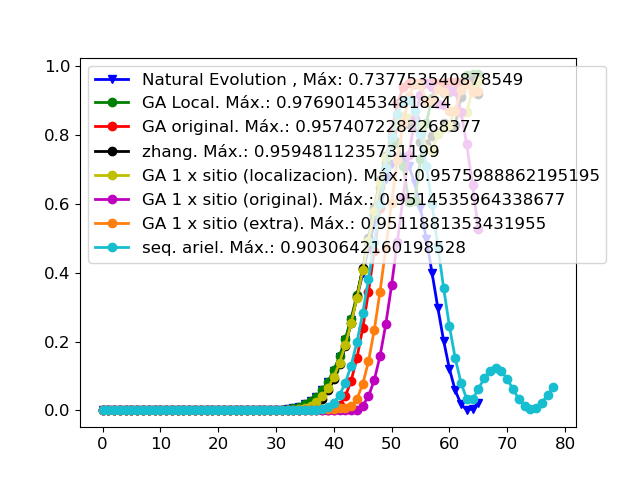

In [14]:
plt.figure()

plot_single_sequence(n13_ga_loc_actions[377][:],13,label='GA Local',actions='original',add_natural=True)
plot_single_sequence(n13_ga_acc_actions[188][:],13,label='GA original',actions='original',add_natural=False)

plot_single_sequence(n13_zhang_per_best[9][:],13,label='zhang',actions='original',add_natural=False)
plot_single_sequence(n13_ga_oaps_actions_lb[42][:],13,label='GA 1 x sitio (localizacion)',actions='oaps',add_natural=False)
plot_single_sequence(n13_ga_oaps_actions_acc[421][:],13,label='GA 1 x sitio (original)',actions='oaps',add_natural=False)
plot_single_sequence(n13_ga_oaps_extra_acc[637][:],13,label='GA 1 x sitio (extra)',actions='extra',add_natural=False)


ariel = [14, 14, 14, 14, 14, 14, 12, 12, 12, 12, 12, 15, 15, 15, 15, 12, 12, 13, 2, 1, 11, 9, 13, 11, 5, 10, 4, 10, 1, 12, 13, 13, 13, 13, 6, 6, 6, 6, 6, 15, 15, 15, 15, 15, 1, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 1, 1, 1, 10, 1, 15, 15, 15, 15, 15, 15, 6, 6, 6, 6, 1, 14, 13]

plot_single_sequence(ariel,13,label='seq. ariel',actions='original',add_natural=False)


Propagacion de autoestados: correcta
Propagacion de autoestados: correcta


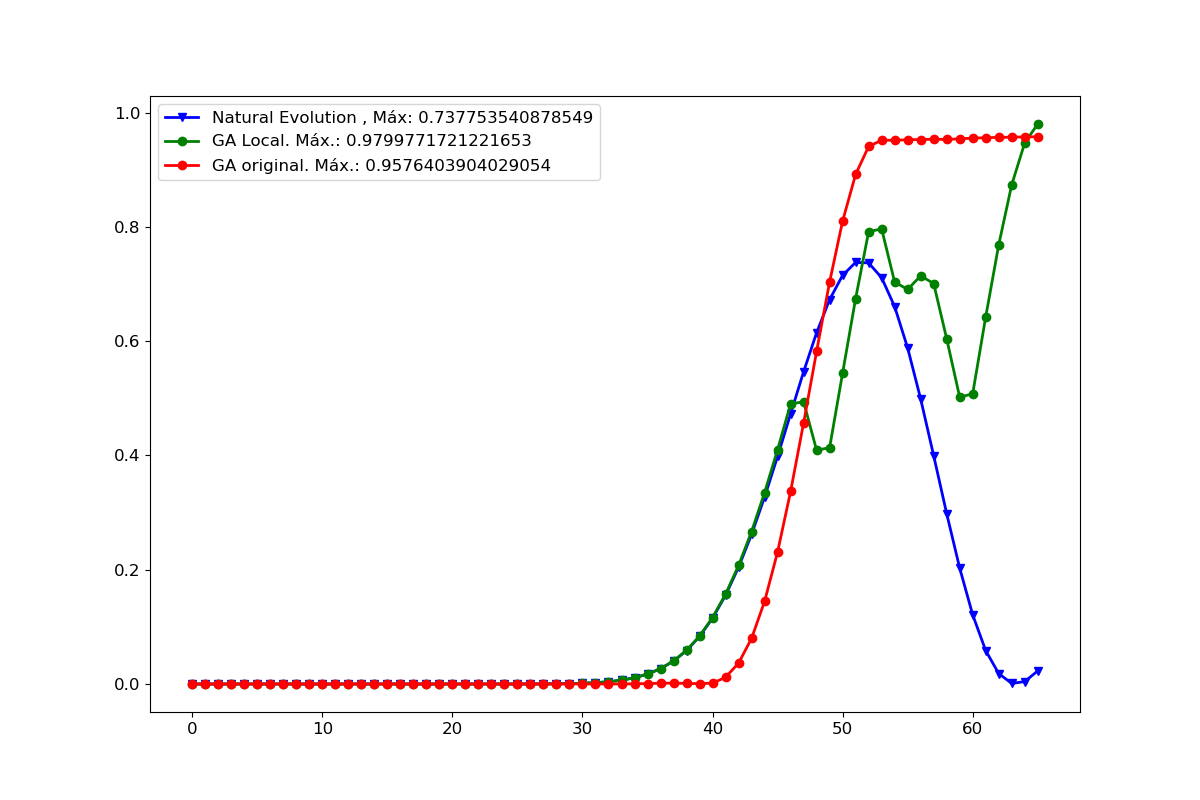

In [15]:
plt.figure(figsize=(12,8))

plot_single_sequence(n13_ga_loc_actions[122][:],13,label='GA Local',actions='original',add_natural=True)
plot_single_sequence(n13_ga_acc_actions[456][:],13,label='GA original',actions='original',add_natural=False)

Propagacion de autoestados: correcta
Propagacion de autoestados: correcta
Propagacion de autoestados: correcta


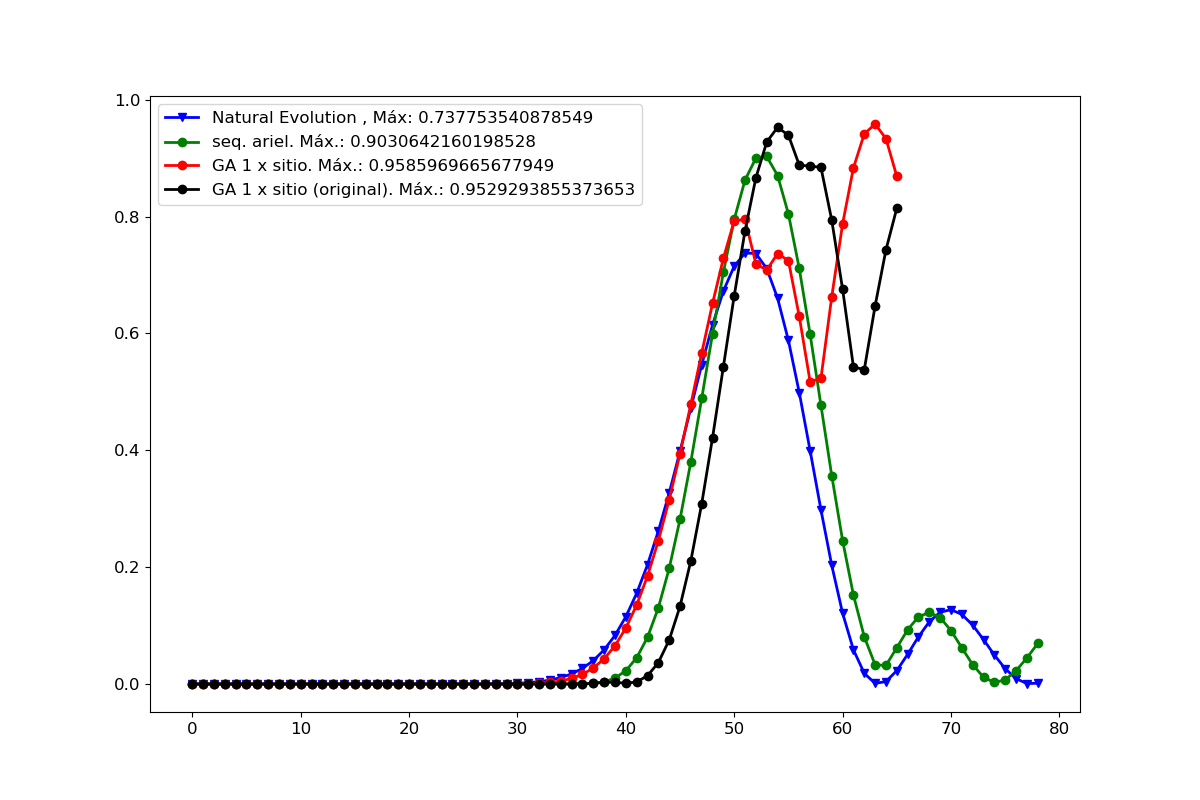

In [16]:
plt.figure(figsize=(12,8))

plot_single_sequence(ariel,13,label='seq. ariel',actions='original',add_natural=True)
plot_single_sequence(n13_ga_oaps_actions_lb[1][:],13,label='GA 1 x sitio',actions='oaps',add_natural=False)
plot_single_sequence(n13_ga_oaps_actions_acc[7][:],13,label='GA 1 x sitio (original)',actions='oaps',add_natural=False)


Propagacion de autoestados: correcta


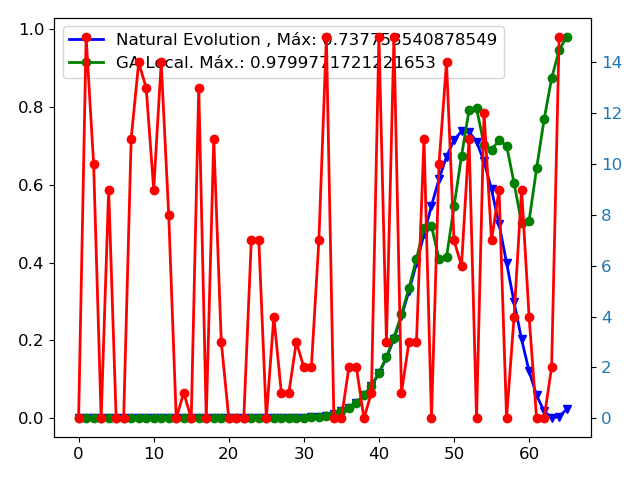

In [17]:
fig,ax1 = plt.subplots()

plot_single_sequence(n13_ga_loc_actions[122][:],13,label='GA Local',actions='original',add_natural=True)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.plot(n13_ga_loc_actions[122][:],'-o',label='Acciones',color='r')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

Propagacion de autoestados: correcta
Propagacion de autoestados: correcta


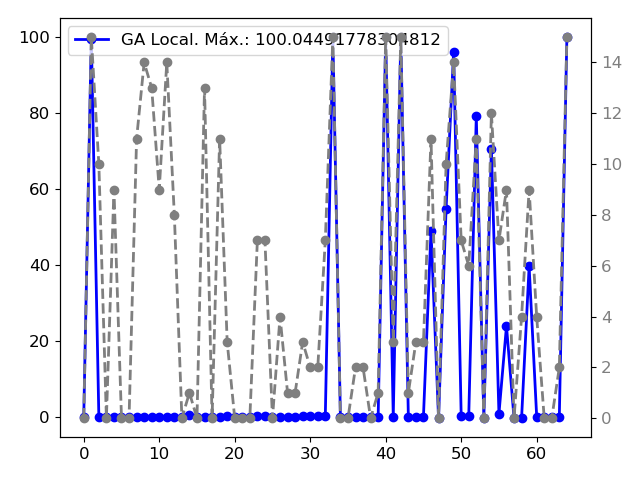

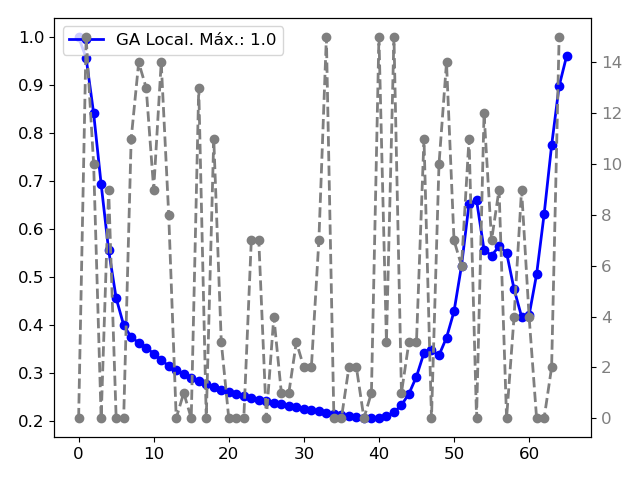

In [18]:
fig = 0
ax1 = 0

plot_exp_value(n13_ga_loc_actions[122][:],13,label='GA Local',actions='original',add_actions=[fig,ax1])
plot_ipr(n13_ga_loc_actions[122][:],13,label='GA Local',actions='original',add_actions=[fig,ax1])
test_sequence = np.hstack((np.zeros(20),n13_ga_loc_actions[122][20:]))


Propagacion de autoestados: correcta
Propagacion de autoestados: correcta


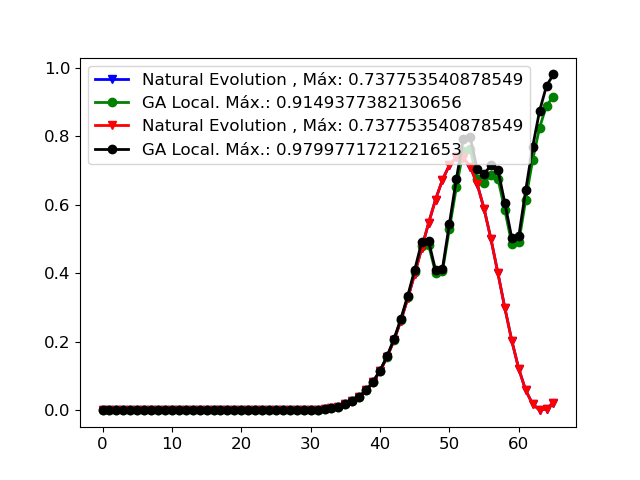

In [19]:
fig,ax1 = plt.subplots()
plot_single_sequence(test_sequence,13,label='GA Local',actions='original',add_natural=True)
plot_single_sequence(n13_ga_loc_actions[122][:],13,label='GA Local',actions='original',add_natural=True)

Propagacion de autoestados: correcta


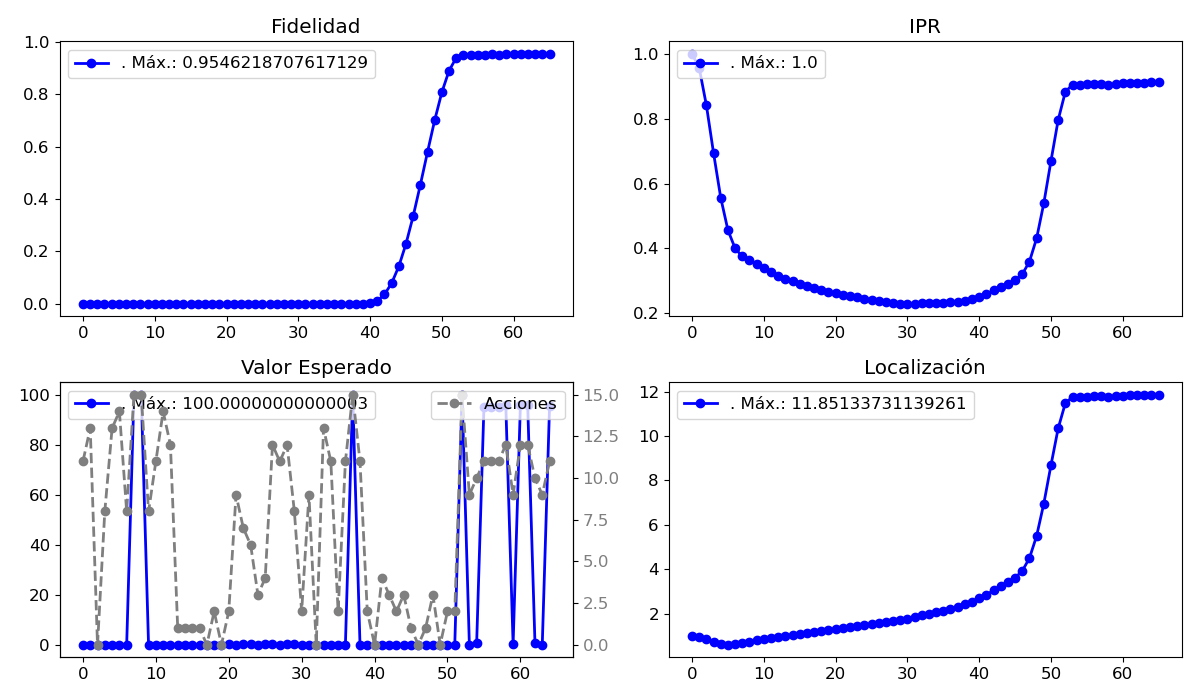

In [20]:
plot_all_metrics(n13_ga_acc_actions[122][:],13,actions='original',add_natural=True,add_actions=[2])

Propagacion de autoestados: correcta


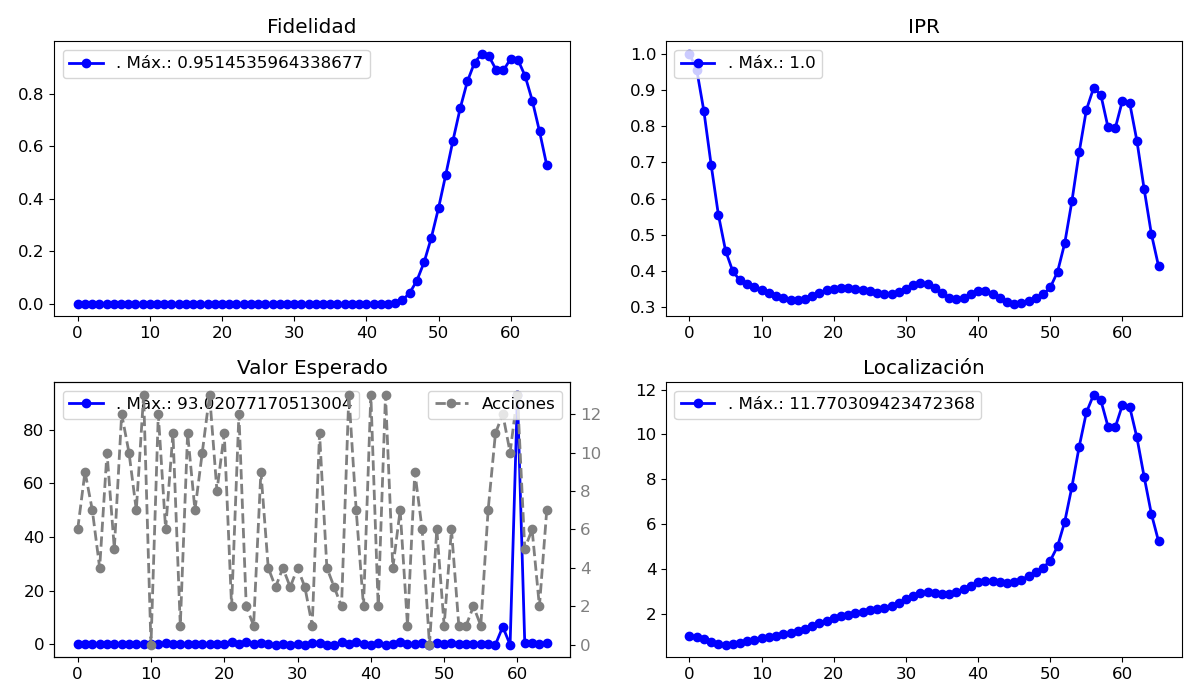

In [21]:
plot_all_metrics(n13_ga_oaps_actions_acc[421][:],13,actions='oaps',add_natural=True,add_actions=[2])

Propagacion de autoestados: correcta


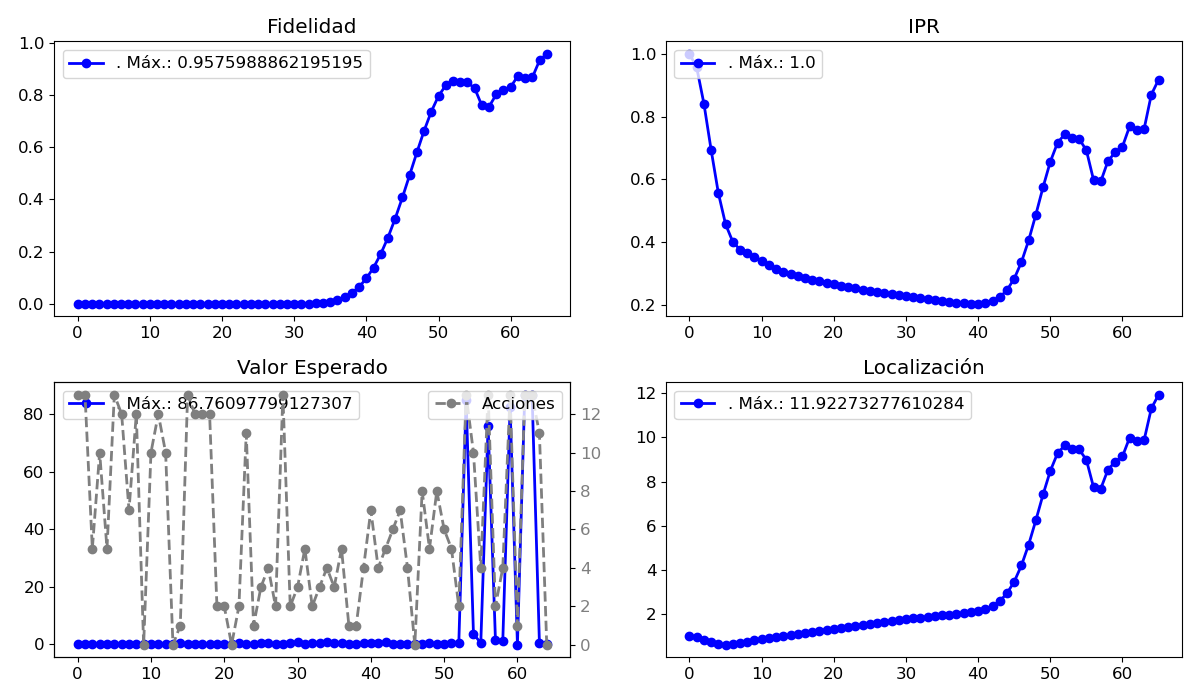

In [22]:
plot_all_metrics(n13_ga_oaps_actions_lb[42][:],13,actions='oaps',add_natural=True,add_actions=[2])

Propagacion de autoestados: correcta


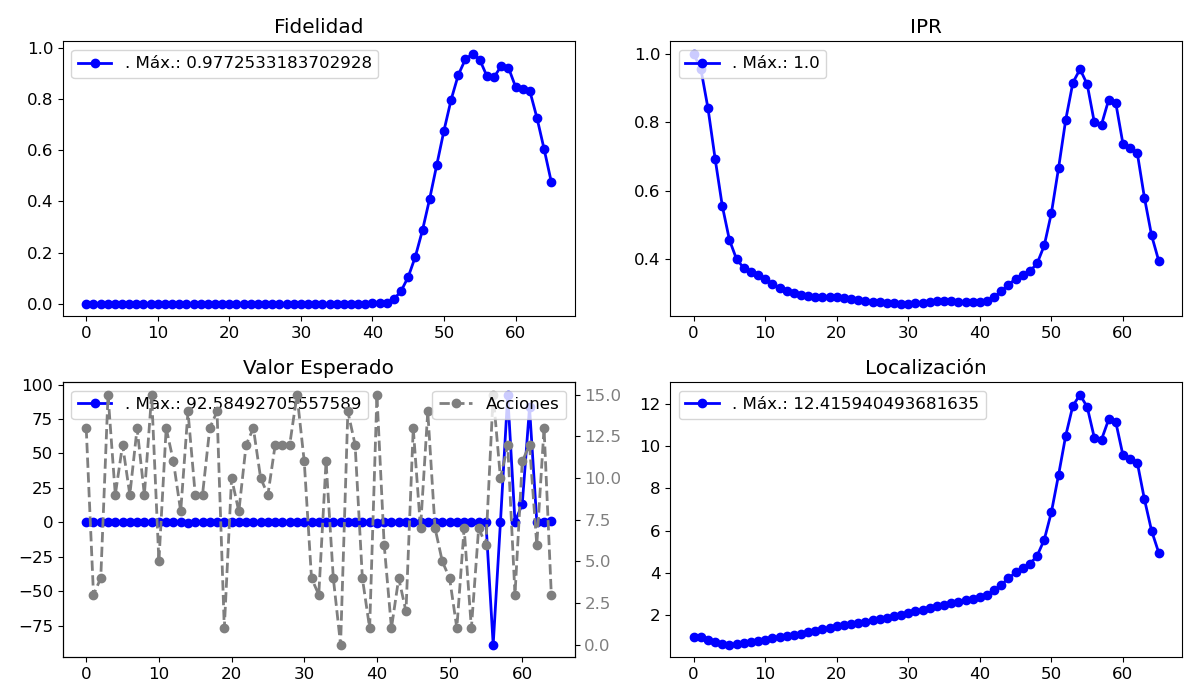

In [23]:
plot_all_metrics(n13_ga_oaps_extra_acc[718][:],13,actions='extra',add_natural=True,add_actions=[2])

Propagacion de autoestados: correcta


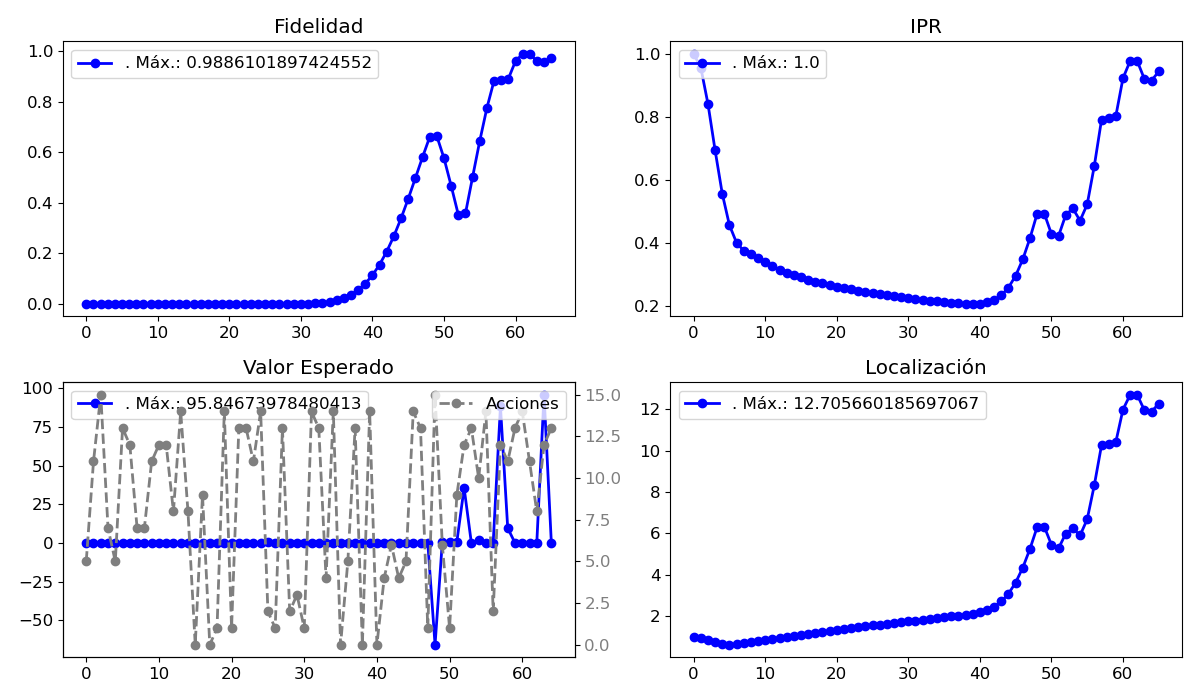

In [24]:
plot_all_metrics(n13_ga_oaps_extra_lb[235][:],13,actions='extra',add_natural=True,add_actions=[2])